In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

In [2]:
def calculate_psd(time_series, sampling_frequency=1):
    """ Calcular a densidade espectral de potência de uma série temporal. """
    frequencies, psd_values = welch(time_series, fs=sampling_frequency, nperseg=1024)
    return frequencies, psd_values


def identify_frequencies(psd_values, frequencies):
    """ Identificar f_L, f_l, f_t com base na análise da PSD. """
    # Este é um exemplo simplificado. Você deve adaptar este método para seu caso específico.
    f_L = frequencies[np.argmax(psd_values)]  # Exemplo: pico mais baixo de frequência
    f_l = frequencies[-1]  # Frequência mais alta disponível
    f_t = frequencies[len(frequencies) // 2]  # Frequência média
    return f_L, f_l, f_t

def calculate_E_fL(freqs, psd, fL):
    return np.trapz(psd[freqs <= fL], freqs[freqs <= fL])

def calculate_cn2(A, P, T, fL, fl, ft, E_fL):
    term1 = ((A*P)/(T**2))**2
    term2 = (E_fL*np.exp(-3*np.log(ft/fL)-5/3*np.log(fl/ft)))/(0.125)
    term3 = fl**(5/3)

    return term1*term2*term3

In [3]:
df = pd.read_csv("../../data/processed/ERA5_Full_Dataset.csv")
df.head()

,time,pressure_level,altitude,temperature,relative_humidity,specific_humidity,u,v,wind_speed,d2m,...,msl,tp,v10,u10,v100,u100,ttr,tcc,wind_speed_10,wind_speed_100
0,1998-12-31 21:00:00,1,58373.873278,266.782809,0.000164,0.000004,-53.115034,-1.046399,53.125341,291.047976,...,101323.855318,0.000109,0.648034,-1.475597,1.009022,-2.811511,-873001.839211,0.495752,1.611625,2.987092
1,1998-12-31 22:00:00,1,58377.070499,266.133571,0.000173,0.000004,-56.079982,4.207988,56.237634,291.102855,...,101362.271230,0.000055,-0.232797,-1.384500,-0.376840,-2.811511,-876066.526497,0.638490,1.403935,2.836653
2,1998-12-31 23:00:00,1,58378.955239,266.425400,0.000167,0.000004,-59.579416,11.225047,60.627622,291.094585,...,101384.923973,0.000068,-0.927978,-0.960242,-1.950172,-2.811511,-904910.642133,0.667170,1.335368,3.421661
3,1999-01-01 00:00:00,1,58377.803403,265.834933,0.000179,0.000004,-61.247199,15.127236,63.087659,290.857967,...,101371.079419,0.000055,-1.210370,-0.514787,-2.980013,0.348545,-854472.070282,0.655588,1.315296,3.000327
4,1999-01-01 01:00:00,1,58371.907529,264.006273,0.000209,0.000004,-63.268755,15.352730,65.104851,290.804592,...,101300.243267,0.000035,-1.281291,-0.089466,-3.089207,0.348545,-833740.362168,0.716397,1.284411,3.108807


In [4]:
df['month'] = pd.to_datetime(df['time']).dt.month
df['hour'] = pd.to_datetime(df['time']).dt.hour
# summer, fall, winter, spring
df['season'] = df['month'].apply(lambda x: 'summer' if x in [12, 1, 2] else 'fall' if x in [3, 4, 5] else 'winter' if x in [6, 7, 8] else 'spring')
# day, night
df['daytime'] = df['hour'].apply(lambda x: 'day' if 6 <= x <= 18 else 'night')
columns = [
    'time', 'pressure_level', 'altitude', 'month', 'hour', 'season', 'daytime',
    'temperature', 'relative_humidity', 'specific_humidity', 'u', 'v', 'wind_speed', 
    'd2m', 't2m', 'msl', 'tp', 'v10', 'u10', 'v100', 'u100', 'ttr', 'tcc',
    'wind_speed_10', 'wind_speed_100',
]

df = df[columns]
df['temperature'] = df['temperature'] - 273.15
df.head()

,time,pressure_level,altitude,month,hour,season,daytime,temperature,relative_humidity,specific_humidity,...,msl,tp,v10,u10,v100,u100,ttr,tcc,wind_speed_10,wind_speed_100
0,1998-12-31 21:00:00,1,58373.873278,12,21,summer,night,-6.367191,0.000164,0.000004,...,101323.855318,0.000109,0.648034,-1.475597,1.009022,-2.811511,-873001.839211,0.495752,1.611625,2.987092
1,1998-12-31 22:00:00,1,58377.070499,12,22,summer,night,-7.016429,0.000173,0.000004,...,101362.271230,0.000055,-0.232797,-1.384500,-0.376840,-2.811511,-876066.526497,0.638490,1.403935,2.836653
2,1998-12-31 23:00:00,1,58378.955239,12,23,summer,night,-6.724600,0.000167,0.000004,...,101384.923973,0.000068,-0.927978,-0.960242,-1.950172,-2.811511,-904910.642133,0.667170,1.335368,3.421661
3,1999-01-01 00:00:00,1,58377.803403,1,0,summer,night,-7.315067,0.000179,0.000004,...,101371.079419,0.000055,-1.210370,-0.514787,-2.980013,0.348545,-854472.070282,0.655588,1.315296,3.000327
4,1999-01-01 01:00:00,1,58371.907529,1,1,summer,night,-9.143727,0.000209,0.000004,...,101300.243267,0.000035,-1.281291,-0.089466,-3.089207,0.348545,-833740.362168,0.716397,1.284411,3.108807


In [5]:
df_day = df[df['daytime'] == 'day']
df_night = df[df['daytime'] == 'night']

In [6]:
def get_CN2_values(df, variable):
    freq_dict = {}
    psd_dict = {}
    fL_dict = {}
    ft_dict = {}
    fl_dict = {}   
    E_fL_dict = {}
    cn2_dict = {}

    for pressure_level in df['pressure_level'].unique():
        # print(f"Calculating for pressure level {pressure_level} hPa")
        aux_df = df[df['pressure_level'] == pressure_level].dropna()
        variable_pressure_level = aux_df[variable].values

        # Calculating PSD and identifying f_L, f_l, f_t
        frequencies, psd_values = calculate_psd(variable_pressure_level)
        freq_dict[pressure_level] = frequencies
        psd_dict[pressure_level] = psd_values
        fL, fl, ft = identify_frequencies(psd_values, frequencies)
        fL_dict[pressure_level] = fL
        ft_dict[pressure_level] = ft
        fl_dict[pressure_level] = fl
        E_fL_dict[pressure_level] = calculate_E_fL(frequencies, psd_values, fL)
        # Parameter to calculate cn2
        A = (80*10**-6)/pressure_level
        P = pressure_level
        T = aux_df['temperature'].mean()
        cn2_dict[pressure_level] = calculate_cn2(A, P, T, fL, fl, ft, E_fL_dict[pressure_level])
        
    return freq_dict, psd_dict, fL_dict, ft_dict, fl_dict, E_fL_dict, cn2_dict

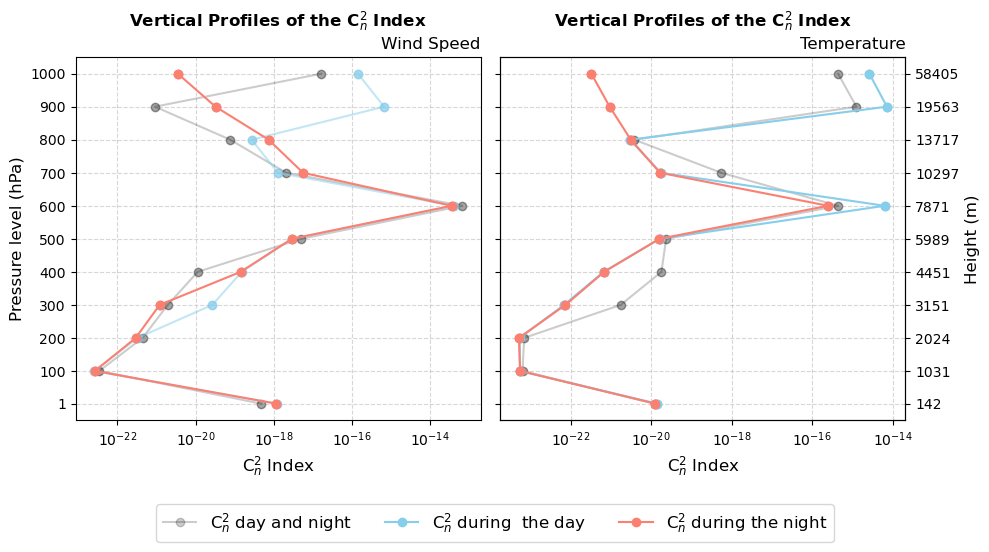

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

heights = df.groupby('pressure_level').agg({'altitude': 'mean'}).to_dict()['altitude']
height_labels = list(heights.values())
pressure_labels = list(heights.keys())

# ax.set_title(r"Vertical Profiles of the C$^{2}_{n}$ Index", fontweight='bold', y=1.02)
ax = axs[0]
ax.set_title(r"Vertical Profiles of the C$^{2}_{n}$ Index", fontweight='bold', y=1.06)
ax.set_title("Wind Speed", loc='right', fontsize=12)
freq_dict, psd_dict, fL_dict, ft_dict, fl_dict, E_fL_dict, cn2_dict = get_CN2_values(df, 'wind_speed')
cn2_labels = list(cn2_dict.values())
ax.plot(cn2_labels, pressure_labels, 'o-', color='black', alpha=0.2)
ax.scatter(cn2_labels, pressure_labels, color='black', alpha=0.2)
ax.plot([], 'o-', color='black', label=r'C$^{2}_{n}$ day and night', alpha=0.2)
ax.set_yticks(pressure_labels)

freq_dict, psd_dict, fL_dict, ft_dict, fl_dict, E_fL_dict, cn2_dict = get_CN2_values(df_day, 'wind_speed')
cn2_labels = list(cn2_dict.values())
ax.plot(cn2_labels, pressure_labels, 'o-', color='skyblue', alpha=0.5)
ax.scatter(cn2_labels, pressure_labels, color='skyblue', alpha=0.5)
ax.plot([], 'o-', color='skyblue', label=r'C$^{2}_{n}$ during  the day')
ax.set_yticks(pressure_labels)

freq_dict, psd_dict, fL_dict, ft_dict, fl_dict, E_fL_dict, cn2_dict = get_CN2_values(df_night, 'wind_speed')
cn2_labels = list(cn2_dict.values())
ax.plot(cn2_labels, pressure_labels, 'o-', color='salmon')
ax.scatter(cn2_labels, pressure_labels, color='salmon')
ax.plot([], 'o-', color='salmon', label=r'C$^{2}_{n}$ during the night')
ax.set_yticks(pressure_labels)

ax = axs[1]
ax.set_title(r"Vertical Profiles of the C$^{2}_{n}$ Index", fontweight='bold', y=1.06)
ax.set_title("Temperature", loc='right', fontsize=12)
freq_dict, psd_dict, fL_dict, ft_dict, fl_dict, E_fL_dict, cn2_dict = get_CN2_values(df, 'temperature')
cn2_labels = list(cn2_dict.values())
ax.plot(cn2_labels, pressure_labels, 'o-', color='black', alpha=0.2)
ax.scatter(cn2_labels, pressure_labels, color='black', alpha=0.2)
ax.plot([], 'o-', color='black', alpha=0.2)
ax.set_yticks(pressure_labels)

freq_dict, psd_dict, fL_dict, ft_dict, fl_dict, E_fL_dict, cn2_dict = get_CN2_values(df_day, 'temperature')
cn2_labels = list(cn2_dict.values())
ax.plot(cn2_labels, pressure_labels, 'o-', color='skyblue')
ax.scatter(cn2_labels, pressure_labels, color='skyblue')
ax.plot([], 'o-', color='skyblue')
ax.set_yticks(pressure_labels)

freq_dict, psd_dict, fL_dict, ft_dict, fl_dict, E_fL_dict, cn2_dict = get_CN2_values(df_night, 'temperature')
cn2_labels = list(cn2_dict.values())
ax.plot(cn2_labels, pressure_labels, 'o-', color='salmon')
ax.scatter(cn2_labels, pressure_labels, color='salmon')
ax.plot([], 'o-', color='salmon')
ax.set_yticklabels(['']*len(pressure_labels))


ax2 = ax.twinx()
ax2.plot(['']*len(pressure_labels), pressure_labels, color='black', alpha=0)
ax2.set_yticks(pressure_labels)
ax2.set_yticklabels([int(v) for v in height_labels[::-1]])
ax2.set_ylabel("Height (m)", fontsize=12)


axs[0].set_xlabel(r"C$^{2}_{n}$ Index", fontsize=12)
axs[0].set_ylabel("Pressure level (hPa)", fontsize=12)
axs[0].grid(ls='--', alpha=0.5)
axs[0].set_xscale('log')

axs[1].set_xlabel(r"C$^{2}_{n}$ Index", fontsize=12)
axs[1].grid(ls='--', alpha=0.5)
axs[1].set_xscale('log')

# create separate legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, -0.005))
fig.tight_layout()

plt.savefig("./results/Daytime_Vertical_Profiles_CN2.png", dpi=72, bbox_inches='tight', pad_inches=0.1, transparent=False)
plt.savefig("./results/Daytime_Vertical_Profiles_CN2.pdf", dpi=150, bbox_inches='tight', pad_inches=0.1, transparent=False)